In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [2]:
#read in files
#already been split into training people and testing groups
#made from impute2

testing_SNPs = pd.read_csv('testing.txt', delimiter=' ', header = None)
training_SNPs = pd.read_csv('training.txt', delimiter = ' ', header = None)
#map22 = pd.read_csv('map22.txt', delimiter = '\t', header = None)
map22_2 = pd.read_csv('chr22.txt', delimiter = ' ', header = None)

In [3]:
#read in map
#find how many SNPs in our training/testing SNPs (they're the same...) are also in our map

#we only have 250 people in our training data
#print(map22[:6][0]) #first col is physical position, second is recombination rate with the next SNP, \
#third is genetic map in cM
print(training_SNPs.shape) 

training_SNPs_arr = training_SNPs[:][2].to_numpy()
SNPs = int(testing_SNPs.shape[0])

#this map doesn't have many cM distances in it
#map22_arr_pos = map22.loc[:][0].to_numpy()

#this map has more data in it
chr22_arr = map22_2.loc[:8000][1].to_numpy() #hard coding to make file smaller (our SNPs all in first 8k)
chr22_cM = map22_2.loc[:8000][2].to_numpy()

#turns out there are a few duplicates in my chr22 map
uniques = np.unique(chr22_arr)
print(len(uniques))

#find indices in training_SNPs_arr where we have a cM distance
indices_in_SNPs = np.where(np.in1d(training_SNPs_arr,chr22_arr))
indices_in_map = np.where(np.in1d(chr22_arr, training_SNPs_arr))

#format into something nicer
idx_map = indices_in_map[0]
idx_SNP = indices_in_SNPs[0]


(5000, 505)
7993


In [4]:
#make a 2 column matrix
#first column = SNP position
#second column = cM distance
#if no cM distance, put -1 for now

cM_map = np.zeros((SNPs,2))
for SNP in range(SNPs):
    #first column = SNP position
    cM_map[SNP, 0] = training_SNPs_arr[SNP]
    
    #check if the SNP is found by indices_in_SNPs
    if SNP in idx_SNP:
        #ind = index for which indices_in_SNPs[index] == SNP
        ind = np.where(idx_SNP == SNP)
        cM_map[SNP, 1] = chr22_cM[idx_map[ind][0]]
    else:
        #unknowns get -1
        cM_map[SNP, 1] = -1
        
#going to initialize this first value to a cM value of 0
cM_map[0][1] = 0


In [5]:
#need to infer missing cM values
#going to just find average value (is this a valid assumption?)

for SNP in range(SNPs):
    counter = 1
    if cM_map[SNP][1] < 0:
        i = 0
        prev_known_SNP = cM_map[SNP-1][1]
        while (cM_map[SNP + i][1] < 0):
            counter +=1 
            i += 1
        next_known_SNP = cM_map[SNP + i][1]
        cM_map[SNP][1] = (next_known_SNP - prev_known_SNP)/counter + prev_known_SNP
      
    
cM_dist = cM_map[:, 1] + 1
print(cM_dist)

[1.         1.         1.         ... 3.61587487 3.61590371 3.61591839]


In [6]:
#convert testing file into 3 part prob dist file
#for each SNP, each person, who is 100% AA, AB, or BB, which is written as 00, 01, or 11, gets 
#turned into one number for AA, one number for AB, one number for BB (so 1, 0,0 as AA, 0, 1, 0 as
#AB, and 0,0,1 for BB)

people = int((testing_SNPs.shape[1]-5) / 2.0)

testing_dist = np.zeros((SNPs, people * 3))
maj_homozygous_test = np.zeros((SNPs, people))
heterozygous_test = np.zeros((SNPs, people))
min_homozygous_test = np.zeros((SNPs, people))

for SNP in range(SNPs):
    for person in range(people):
        if (testing_SNPs.loc[SNP, 5 + person*2] == 0) and (testing_SNPs.loc[SNP, 6 + person*2] == 0):
            maj_homozygous_test[SNP, person] = 1
        elif (testing_SNPs.loc[SNP, 5 + person*2] == 1) and (testing_SNPs.loc[SNP, 6 + person*2] == 0):
            heterozygous_test[SNP, person] = 1
        elif (testing_SNPs.loc[SNP, 5 + person*2] == 0) and (testing_SNPs.loc[SNP, 6 + person*2] == 1):
            heterozygous_test[SNP, person] = 1
        elif (testing_SNPs.loc[SNP, 5 + person*2] == 1) and (testing_SNPs.loc[SNP, 6 + person*2] == 1):
            min_homozygous_test[SNP, person] = 1
            


In [7]:
#convert training file into 3 part prob dist file
#for each SNP, each person, who is 100% AA, AB, or BB, which is written as 00, 01, or 11, gets 
#turned into one number for AA, one number for AB, one number for BB (so 1, 0,0 as AA, 0, 1, 0 as
#AB, and 0,0,1 for BB)

people_training = int((training_SNPs.shape[1]-5) / 2.0)

training_dist = np.zeros((SNPs, people_training * 3))
maj_homozygous_train = np.zeros((SNPs, people_training))
heterozygous_train = np.zeros((SNPs, people_training))
min_homozygous_train = np.zeros((SNPs, people_training))

for SNP in range(SNPs):
    for person in range(people_training):
        if (training_SNPs.loc[SNP, 5 + person*2] == 0) and (training_SNPs.loc[SNP, 6 + person*2] == 0):
            maj_homozygous_train[SNP, person] = 1
        elif (training_SNPs.loc[SNP, 5 + person*2] == 1) and (training_SNPs.loc[SNP, 6 + person*2]) == 0:
            heterozygous_train[SNP, person] = 1
        elif (training_SNPs.loc[SNP, 5 + person*2] == 0) and (training_SNPs.loc[SNP, 6 + person*2] == 1):
            heterozygous_train[SNP, person] = 1
        elif (training_SNPs.loc[SNP, 5 + person*2] == 1) and (training_SNPs.loc[SNP, 6 + person*2] == 1):
            min_homozygous_train[SNP, person] = 1


In [8]:
#constants, based on our data
maj_homo_train_T = maj_homozygous_train.transpose()
hetero_train_T = heterozygous_train.transpose()
min_homo_train_T = min_homozygous_train.transpose()

maj_homo_test_T = maj_homozygous_test.transpose()
hetero_test_T = heterozygous_test.transpose()
min_homo_test_T = min_homozygous_test.transpose()
offset = 25
thin_var = 0.1
idx_imputing = np.random.choice(int((maj_homo_train_T.shape[1])), int((maj_homo_train_T.shape[1]) * thin_var), replace = False)
missing_idx = np.sort(idx_imputing)
missing_idx = list(missing_idx)
missing_indices = []
for x in missing_idx:
    if (x < offset):
        missing_idx.remove(x)
    elif (x > int((maj_homo_train_T.shape[1])) - offset - 1):
        missing_idx.remove(x)
    else:
        missing_indices.append(x)    

In [9]:
def first_clean(orig_data, offset, people):
    imputable_maj_train = orig_data[:, orig_data.shape[1]-offset]

    mega_training_data_maj = np.zeros((people * orig_data.shape[1], 2*offset))
    
    mega_labels_maj = np.zeros((orig_data.shape[1] * people))

    maj_train_scaled = (((((orig_data * 2)+1)*0.5)-1)*2)

    return(maj_train_scaled, mega_training_data_maj, mega_labels_maj)

In [10]:
def second_clean(orig_data, idx_range_int, diff_vec):
    train_val_het = orig_data[:,idx_range_int]
        
    train_val_het = train_val_het * diff_vec
    
    return(train_val_het)

In [11]:
#THIS IS CLEARLY THE GOOD ONE
import time
import pdb

def set_up_data(offset, thin_var):
    np.random.seed(0)

    #create indices that will be "missing"
    idx_imputing = np.random.choice(int((maj_homo_train_T.shape[1])), int((maj_homo_train_T.shape[1]) * thin_var), replace = False)
    missing_idx = np.sort(idx_imputing)
    missing_idx = list(missing_idx)
    missing_indices = []
    for x in missing_idx:
        if (x < offset):
            missing_idx.remove(x)
        elif (x > int((maj_homo_train_T.shape[1])) - offset - 1):
            missing_idx.remove(x)
        else:
            missing_indices.append(x)    
    kept_indices = [row for row in range(maj_homo_train_T.shape[1]) if row not in missing_indices]

    people_training = int((training_SNPs.shape[1]-5) / 2.0)
    
   
    
    maj_train_scaled, mega_training_data_maj, mega_training_labels_maj = first_clean(maj_homo_train_T, offset, people_training)
    min_train_scaled, mega_training_data_min, mega_training_labels_min = first_clean(min_homo_train_T, offset, people_training)
    het_train_scaled, mega_training_data_het, mega_training_labels_het = first_clean(hetero_train_T, offset, people_training)

    people_testing = int((testing_SNPs.shape[1]-5) / 2.0)


    maj_testing_scaled, mega_testing_data_maj, mega_testing_labels_maj = first_clean(maj_homo_test_T, offset, people_testing)
    min_testing_scaled, mega_testing_data_min, mega_testing_labels_min = first_clean(min_homo_test_T, offset, people_testing)
    het_testing_scaled, mega_testing_data_het, mega_testing_labels_het = first_clean(hetero_test_T, offset, people_testing)

    
    start_train_fill_pos = 0
    end_train_fill_pos = maj_homo_train_T.shape[0]
    start_test_fill_pos = 0
    end_test_fill_pos = maj_homo_test_T.shape[0]
    
    #add labels to label vector
    people_training = int((training_SNPs.shape[1]-5) / 2.0)
    people_testing = int((testing_SNPs.shape[1]-5) / 2.0)
    
    #for SNP in range((maj_homo_train_T.shape[1] - offset*2), (maj_homo_train_T.shape[1] - offset)):
    for SNP in range(offset, (maj_homo_train_T.shape[1] - offset)): #offset to ncol maj_homo_train_T-offset +1
        #print(sum(maj_homo_train_T[:,SNP]))
        
        #the SNP being imputed - the label
        test_val_maj = maj_homo_train_T[:,SNP]
        test_val_min = min_homo_train_T[:,SNP]
        test_val_het = hetero_train_T[:,SNP]

        #calculate the data
        below_start_offset = SNP - 1
        while below_start_offset not in kept_indices:
            below_start_offset -= 1
        below_index = kept_indices.index(below_start_offset)

        above_start_offset = SNP + 1
        while above_start_offset not in kept_indices:
            above_start_offset += 1
        above_index = kept_indices.index(above_start_offset)
        
        idx_range = np.r_[kept_indices[(below_index-offset+1):below_index+1],
             kept_indices[above_index:above_index+offset]]
        idx_range_int = [int(i) for i in idx_range]
        
        diff_vec = np.abs(cM_dist[idx_range_int] - cM_dist[SNP])

        train_val_maj = second_clean(maj_train_scaled, idx_range_int, diff_vec)
        train_val_min = second_clean(min_train_scaled, idx_range_int, diff_vec)
        train_val_het = second_clean(het_train_scaled, idx_range_int, diff_vec)
        test_val_maj = second_clean(maj_testing_scaled, idx_range_int, diff_vec)
        test_val_min = second_clean(min_testing_scaled, idx_range_int, diff_vec)
        test_val_het = second_clean(het_testing_scaled, idx_range_int, diff_vec)
    
        mega_training_labels_maj[start_train_fill_pos:end_train_fill_pos] = maj_homo_train_T[:,SNP]
    
        #mega_training_labels_maj[((SNP-offset) * people_training) : ((SNP-offset + 1) * people_training)] = maj_homo_train_T[:,SNP]
        mega_training_labels_min[((SNP-offset) * people_training) : ((SNP-offset + 1) * people_training)] = min_homo_train_T[:,SNP]
        mega_training_labels_het[((SNP-offset) * people_training) : ((SNP-offset + 1) * people_training)] = hetero_train_T[:,SNP]
        
        mega_testing_labels_maj[((SNP-offset) * people_testing) : ((SNP-offset + 1) * people_testing)] = maj_homo_test_T[:,SNP]
        mega_testing_labels_min[((SNP-offset) * people_testing) : ((SNP-offset + 1) * people_testing)] = min_homo_test_T[:,SNP]
        mega_testing_labels_het[((SNP-offset) * people_testing) : ((SNP-offset + 1) * people_testing)] = hetero_test_T[:,SNP]
        
        #add to the mega data
        mega_training_data_maj[(SNP-offset) * people_training : (SNP-offset + 1) * people_training, :] = train_val_maj
        mega_training_data_min[(SNP-offset) * people_training : (SNP-offset + 1) * people_training, :] = train_val_min
        mega_training_data_het[(SNP-offset) * people_training : (SNP-offset + 1) * people_training, :] = train_val_het
        
        mega_testing_data_maj[(SNP-offset) * people_testing : (SNP-offset + 1) * people_testing, :] = test_val_maj
        mega_testing_data_min[(SNP-offset) * people_testing : (SNP-offset + 1) * people_testing, :] = test_val_min
        mega_testing_data_het[(SNP-offset) * people_testing : (SNP-offset + 1) * people_testing, :] = test_val_het

        start_train_fill_pos += maj_homo_train_T.shape[0]
        end_train_fill_pos += maj_homo_train_T.shape[0]
        start_test_fill_pos += maj_homo_test_T.shape[0]
        end_test_fill_pos += maj_homo_test_T.shape[0]
        
    end_train_fill_pos -= maj_homo_train_T.shape[0]
    end_test_fill_pos -= maj_homo_test_T.shape[0]
    
    mega_training_labels_min = mega_training_labels_min[0:end_train_fill_pos]
    mega_training_labels_maj = mega_training_labels_maj[0:end_train_fill_pos]
    mega_training_labels_het = mega_training_labels_het[0:end_train_fill_pos]
    
    mega_testing_labels_min = mega_testing_labels_min[0:end_test_fill_pos]
    mega_testing_labels_maj = mega_testing_labels_maj[0:end_test_fill_pos]
    mega_testing_labels_het = mega_testing_labels_het[0:end_test_fill_pos]
    
    mega_training_data_maj = mega_training_data_maj[0:end_train_fill_pos]
    mega_training_data_min = mega_training_data_min[0:end_train_fill_pos]
    mega_training_data_het = mega_training_data_het[0:end_train_fill_pos]
    
    mega_testing_data_maj = mega_testing_data_maj[0:end_test_fill_pos]
    mega_testing_data_min = mega_testing_data_min[0:end_test_fill_pos]
    mega_testing_data_het = mega_testing_data_het[0:end_test_fill_pos]
        
    return(mega_training_labels_maj, mega_training_labels_min, mega_training_labels_het, 
               mega_testing_labels_maj, mega_testing_labels_min, mega_testing_labels_het,
              mega_training_data_maj, mega_training_data_min, mega_training_data_het,
              mega_testing_data_maj, mega_testing_data_min, mega_testing_data_het)
    
    


In [12]:
offset = 25
thin = 0.1
mega_training_labels_maj, mega_training_labels_min, mega_training_labels_het, mega_testing_labels_maj, mega_testing_labels_min, mega_testing_labels_het, mega_training_data_maj, mega_training_data_min, mega_training_data_het, mega_testing_data_maj, mega_testing_data_min, mega_testing_data_het = set_up_data(offset,thin)

In [16]:
#For debugging
#x=maj_homo_train_T.shape[1] - offset
#min_homo_train_T[:,x]

#print(np.where(mega_training_labels_maj == 1))
#len(mega_training_labels_maj)

#print(mega_training_labels_maj[1237000:1237500])
#print(maj_homo_train_T.shape[0])
#1250000 - 1237500

#maj_homo_train_T.shape[0]
#something = np.zeros(10000)
#filler = np.ones(5000)
#start = 0
#end = filler.shape[0]



In [31]:
print(mega_training_data_maj.shape, mega_training_labels_maj.shape)

kept_percent = 0.25

idx_tuning = np.random.choice(int((mega_training_data_maj.shape[0])), int((mega_training_data_maj.shape[0] * kept_percent) * thin_var), replace = False)
tuning_maj = [mega_training_data_maj[i, :] for i in idx_tuning]
tuning_maj = np.vstack(tuning_maj)
tuning_labs = [mega_training_labels_maj[i] for i in idx_tuning]


(1237500, 50) (1237500,)
<class 'numpy.ndarray'>


In [35]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 400, num = 10)]
random_grid = {'n_estimators': n_estimators}

rf = RandomForestClassifier(random_state = 42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 3, cv = 3, verbose=2, random_state=42)
rf_random.fit(tuning_maj, tuning_labs)
rf_random.best_params_

snpX_maj = RandomForestClassifier(n_estimators = rf_random.best_params_["n_estimators"])
snpX_min = RandomForestClassifier(n_estimators = rf_random.best_params_["n_estimators"])
snpX_het = RandomForestClassifier(n_estimators = rf_random.best_params_["n_estimators"])
#snpX_maj = RandomForestClassifier(n_estimators = 100, max_depth=3, class_weight = "balanced")
#snpX_min = RandomForestClassifier(n_estimators = 100, max_depth=3, class_weight = "balanced")
#snpX_het = RandomForestClassifier(n_estimators = 100, max_depth=3, class_weight = "balanced")

print("now fitting")
snpX_maj.fit(mega_training_data_maj, mega_training_labels_maj)
snpX_min.fit(mega_training_data_min, mega_training_labels_min)
snpX_het.fit(mega_training_data_het, mega_training_labels_het)

probs_maj = snpX_maj.predict_proba(mega_testing_data_maj)
probs_min = snpX_min.predict_proba(mega_testing_data_min)
probs_het = snpX_het.predict_proba(mega_testing_data_het)



Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_estimators=366 ................................................
[CV] ................................. n_estimators=366, total= 1.3min
[CV] n_estimators=366 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] ................................. n_estimators=366, total= 1.2min
[CV] n_estimators=366 ................................................
[CV] ................................. n_estimators=366, total= 1.3min
[CV] n_estimators=133 ................................................
[CV] ................................. n_estimators=133, total=  27.0s
[CV] n_estimators=133 ................................................
[CV] ................................. n_estimators=133, total=  26.8s
[CV] n_estimators=133 ................................................
[CV] ................................. n_estimators=133, total=  27.9s
[CV] n_estimators=266 ................................................
[CV] ................................. n_estimators=266, total=  54.9s
[CV] n_estimators=266 ................................................
[CV] ................................. n_estimators=266, total=  54.2s
[CV] n_estimators=266 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  8.0min finished


now fitting


In [46]:
from sklearn.metrics import roc_auc_score


print("ROC Maj", roc_auc_score(mega_testing_labels_maj, probs_maj[:,1]))
print("ROC Min", roc_auc_score(mega_testing_labels_min, probs_min[:,1]))
print("ROC Het", roc_auc_score(mega_testing_labels_het, probs_het[:,1]))

three_preds = np.vstack((probs_maj[:,1], probs_min[:,1], probs_het[:,1])).T
three_labs = np.vstack((mega_testing_labels_maj, mega_testing_labels_min, mega_testing_labels_het)).T

norm_val = np.sum(three_labs, axis = 1)
three_labs = three_labs / norm_val[:, np.newaxis]

norm_val = np.sum(three_preds, axis = 1)
three_preds = three_preds / norm_val[:, np.newaxis]

hell = np.nan_to_num(1-np.sqrt(1-np.sum(np.sqrt(np.multiply(three_preds, three_labs)), axis = 1)))

##change here!
hell_25_10_RF = hell
np.savetxt("hellinger_off25_thin10p_RF", hell)

## SAVE THESE
print("SAVE THESE")
print("hellinger mean", np.mean(hell))
print("number of trees", rf_random.best_params_)

0.9763211193141336
0.9819443202098126
0.9807480730472876
[0.77762828 0.17077701 1.31146287 ... 1.         1.         1.        ]


/Users/majakus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/majakus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


SAVE THESE
hellinger mean 0.8724223806262569
number of trees {'n_estimators': 133}


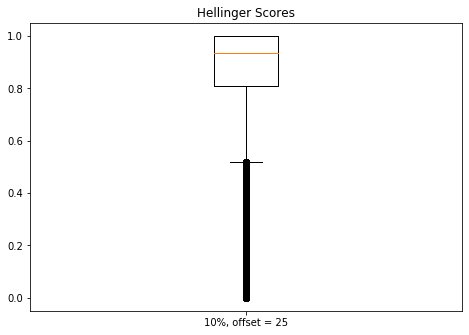

In [43]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
#ax.set_xticks([1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels(['10%, offset = 25'])
ax.boxplot(hell_25_10_RF, showfliers=True)
plt.title("Hellinger Scores")

plt.show()


In [ ]:
from sklearn.svm import LinearSVC

C = [0.000001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10]
random_grid = {'C' : C}


svm = LinearSVC(random_state = 42)
svm_random = RandomizedSearchCV(estimator = svm, param_distributions = random_grid, n_iter = 3, cv = 3, verbose=2, random_state=42)
svm_random.fit(mega_training_data_maj, mega_training_labels_maj)
svm_random.best_params_

snpX_maj = LinearSVC(C = svm_random.best_params_["C"])
snpX_min = LinearSVC(C = svm_random.best_params_["C"])
snpX_het = LinearSVC(C = svm_random.best_params_["C"])
#snpX_maj = RandomForestClassifier(n_estimators = 100, max_depth=3, class_weight = "balanced")
#snpX_min = RandomForestClassifier(n_estimators = 100, max_depth=3, class_weight = "balanced")
#snpX_het = RandomForestClassifier(n_estimators = 100, max_depth=3, class_weight = "balanced")

#print("now fitting")
snpX_maj.fit(mega_training_data_maj, mega_training_labels_maj)
snpX_min.fit(mega_training_data_min, mega_training_labels_min)
snpX_het.fit(mega_training_data_het, mega_training_labels_het)

probs_maj = snpX_maj.predict_proba(mega_testing_data_maj)
probs_min = snpX_min.predict_proba(mega_testing_data_min)
probs_het = snpX_het.predict_proba(mega_testing_data_het)

In [18]:
from sklearn.metrics import roc_auc_score


print(roc_auc_score(mega_testing_labels_maj, probs_maj[:,1]))
print(roc_auc_score(mega_testing_labels_min, probs_min[:,1]))
print(roc_auc_score(mega_testing_labels_het, probs_het[:,1]))

0.836899101526137
0.6771873510133398
0.7412513977447419


In [24]:


three_preds = np.vstack((probs_maj[:,1], probs_min[:,1], probs_het[:,1])).T
three_labs = np.vstack((mega_testing_labels_maj, mega_testing_labels_min, mega_testing_labels_het)).T

norm_val = np.sum(three_labs, axis = 1)
three_labs = three_labs / norm_val[:, np.newaxis]

norm_val = np.sum(three_preds, axis = 1)
three_preds = three_preds / norm_val[:, np.newaxis]

hell = 1-np.sqrt(1-np.sum(np.sqrt(np.multiply(three_preds, three_labs)), axis = 1))
print(np.mean(hell))

[1.36823329 1.38125997 1.42463973 ... 1.41866555 1.41574654 1.40033252]
[[0.39673272 0.58840192 0.38309865]
 [0.39300086 0.5822166  0.40604251]
 [0.39673272 0.55904855 0.46885847]
 ...
 [0.39300086 0.52840085 0.49726384]
 [0.39300086 0.52444724 0.49829845]
 [0.39300086 0.5677779  0.43955377]]
0.3728049542103677


In [30]:


three_preds = np.vstack((probs_maj[:,1], probs_min[:,1], probs_het[:,1])).T
three_labs = np.vstack((mega_testing_labels_maj, mega_testing_labels_min, mega_testing_labels_het)).T

maxed_three_preds = np.zeros((three_preds.shape[0], three_preds.shape[1]))
max_values = np.max(three_preds, axis = 1)
for i in range(three_preds.shape[0]):
    maxed_three_preds[i, three_preds[i,:] == max_values[i]] = 1


hell = 1-np.sqrt(1-np.sum(np.sqrt(np.multiply(three_preds, three_labs)), axis = 1))
print(np.mean(hell))

0.47458347629525705


In [29]:
three_preds[i,:] == max_values[i]

array([0.39673272, 0.58840192, 0.38309865])

In [149]:
from sklearn.metrics import roc_auc_score

print(mega_testing_labels_maj)
print(probs_maj)
roc_auc_score(mega_testing_labels_maj,probs_maj[:,1])


H_scores_final = helle_score(probs_maj, probs_min, probs_het, 
                            mega_testing_labels_maj,  mega_testing_labels_min,  mega_testing_labels_het)

[1. 1. 0. ... 0. 0. 0.]
[[1.14061502e-04 9.99885938e-01]
 [1.60145971e-01 8.39854029e-01]
 [1.14061502e-04 9.99885938e-01]
 ...
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]]
0
0.0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
21

/home/quenton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/home/quenton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/home/quenton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/quenton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/home/quenton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/home/quenton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513


2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296


3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953
3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
0.0031620553359683794
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
401

5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519
5520
5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620
5621
5622
5623
5624
5625
5626
5627
5628
5629
5630
5631
5632
5633
5634
5635
5636
5637
5638
5639
5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652
5653


KeyboardInterrupt: 

In [10]:
#REWRITE THIS
import math
def testing_faster(offset, thin_var, snpX_maj, snpX_min, snpX_het):
    t1 = time.time()

    np.random.seed(0)

    #create indices that will be "missing"
    idx_imputing = np.random.choice(int((maj_homo_test_T.shape[1])), int((maj_homo_test_T.shape[1]) * thin_var), replace = False)
    missing_idx = np.sort(idx_imputing)
    missing_idx = list(missing_idx)
    missing_indices = []
    for x in missing_idx:
        if (x < offset):
            missing_idx.remove(x)
        elif (x > int((maj_homo_test_T.shape[1])) - offset - 1):
            missing_idx.remove(x)
        else:
            missing_indices.append(x)    
    kept_indices = [row for row in range(maj_homo_test_T.shape[1]) if row not in missing_indices]
    
    H_scores_final = []
    
    maj_test_scaled = maj_homo_test_T +1
    min_test_scaled = min_homo_test_T +1
    het_test_scaled = hetero_test_T +1    
    
    maj_test_scaled = maj_test_scaled * cM_dist
    min_test_scaled = min_test_scaled * cM_dist
    het_test_scaled = het_test_scaled * cM_dist
    
    correct_size_ones = np.ones((maj_test_scaled.shape[0], 2*offset))
    
    for SNP in missing_indices:

        #create correct labels
        test_label_maj = maj_homo_test_T[:,SNP]
        test_label_min = min_homo_test_T[:,SNP]
        test_label_het = hetero_test_T[:,SNP]

        test_val_cM = cM_dist[SNP]

        #calculate the data
        below_start_offset = SNP - 1
        while below_start_offset not in kept_indices:
            below_start_offset -= 1
        below_index = kept_indices.index(below_start_offset)

        above_start_offset = SNP + 1
        while above_start_offset not in kept_indices:
            above_start_offset += 1
        above_index = kept_indices.index(above_start_offset)
        
        idx_range = np.r_[kept_indices[(below_index-offset+1):below_index+1],
             kept_indices[above_index:above_index+offset]]
        idx_range_int = [int(i) for i in idx_range]

        test_val_maj = maj_test_scaled[:,idx_range_int] #1 or -1 times cM
        test_val_min = min_test_scaled[:,idx_range_int]
        test_val_het = het_test_scaled[:,idx_range_int]
        
        #test_val_maj = np.abs(test_val_maj - test_val_cM * correct_size_ones)
        #test_val_maj = np.abs(test_val_maj - np.max(test_val_maj))
        
        test_val_maj = np.abs(np.abs(test_val_maj) - test_val_cM * correct_size_ones)
        test_val_maj = np.nan_to_num(np.reciprocal(test_val_maj))
        
        #test_val_min = np.abs(test_val_min - test_val_cM * correct_size_ones)
        #test_val_min = np.abs(test_val_min - np.max(test_val_min))

        test_val_min = np.abs(np.abs(test_val_min) - test_val_cM * correct_size_ones)
        test_val_min = np.nan_to_num(np.reciprocal(test_val_min))

        #test_val_het = np.abs(test_val_het - test_val_cM * correct_size_ones)
        #test_val_het = np.abs(test_val_het - np.max(test_val_het))
        
        test_val_het = np.abs(np.abs(test_val_het) - test_val_cM * correct_size_ones)
        test_val_het = np.nan_to_num(np.reciprocal(test_val_het))

        
        
        predict_maj = snpX_maj.predict(test_val_maj)
        predict_min = snpX_min.predict(test_val_min)
        predict_het = snpX_het.predict(test_val_het)


        #Accuracy for Hellinger score
        probs_maj = snpX_maj.predict_proba(test_val_maj)
        probs_min = snpX_min.predict_proba(test_val_min)
        probs_het = snpX_het.predict_proba(test_val_het)

        #Normalize for Hellinger score
        #if any are all one dimension rather than two, means it is never that. Add a second col anyway
        '''probs_het = np.zeros((probs_hetero.shape[0], 2))
        if probs_hetero.shape[1] == 1:
            for i in range((probs_hetero.shape[0])):
                probs_het[i][0] = probs_hetero[i]
        else:
            probs_het = probs_hetero

        probs_maj = np.zeros((probs_maj_homo.shape[0], 2))
        if probs_maj_homo.shape[1] == 1:
            for i in range((probs_maj_homo.shape[0])):
                probs_maj[i][0] = probs_maj_homo[i]
        else:
            probs_maj = probs_maj_homo


        probs_min = np.zeros((probs_min_homo.shape[0], 2))
        if probs_min_homo.shape[1] == 1:
            for i in range((probs_min_homo.shape[0])):
                probs_min[i][0] = probs_min_homo[i]
        else:
            probs_min = probs_min_homo'''


        #HERE --> create "normalized" distributions for the three
        prob_dist_predict = np.zeros(( probs_min.shape[0], 3))
        for person in range(probs_min.shape[0]):
            total = probs_min[person][1] + probs_maj[person][1] + probs_het[person][1]
            prob_dist_predict[person][0] = probs_maj[person][1] / total
            prob_dist_predict[person][1] = probs_het[person][1] / total
            prob_dist_predict[person][2] = probs_min[person][1] / total

        #calculate actual prob_dist_actual
        prob_dist_actual = np.zeros((probs_min.shape[0], 3))
        H_score = []

        for person in range((probs_min.shape[0])):
            sum_total = test_label_maj[person] + test_label_het[person] +\
            test_label_min[person]
            prob_dist_actual[person][0] = test_label_maj[person] / sum_total
            prob_dist_actual[person][1] = test_label_het[person] / sum_total
            prob_dist_actual[person][2] = test_label_min[person] / sum_total

            sqrt_sum = math.sqrt(prob_dist_actual[person][0] * prob_dist_predict[person][0]) + \
                math.sqrt(prob_dist_actual[person][1] * prob_dist_predict[person][1]) + \
                math.sqrt(prob_dist_actual[person][2] * prob_dist_predict[person][2])
            if sqrt_sum > 1.0:
                sqrt_sum = 1.0
            H_score.append(1 - math.sqrt(1-sqrt_sum))
        H_scores_final.append(H_score)
    t2 = time.time()
    total_time = t2-t1

    return H_scores_final, total_time



In [11]:
offset = 25
thin_var = 0.1
time_off25_thin0p1_train, snpX_maj, snpX_min, snpX_het = training_faster(offset = offset, thin_var = 0.1)
H_scores_off25_thin0p1, time_off25_thin0p1_test = testing_faster(offset, thin_var, snpX_maj, snpX_min, snpX_het)

flat_H_off25_thin0p1 = [item for sublist in H_scores_off25_thin0p1 for item in sublist]

np.savetxt("H_scores_off25_thin0p1_RF", flat_H_off25_thin0p1, delimiter = ' ')
print(time_off25_thin0p1_train, time_off25_thin0p1_test)


25
4615.614606490129
26
755.1888659961688
27
3383.8113103565433
28
3590.983432019126
29
3590.983432019126
30
1139.7608088551124
31
1139.7608088551124
32
1139.7608088551124
33
1139.760808855401
34
1139.760808855401
35
1035.9020413990793
36
1035.9020413993176
37
1035.9020413993176
38
1642.5985640288454
39
17575.80462988479
40
1642.5985640288454
41
524.2596461009886
42
524.2596461009886
43
466.30478803627193
44
4218.193112958803
45
4218.193112958803
46
4218.193112958803
47
4218.193112958803
48
543.9948401140791
49
1087.9896802282897
50
6356.793637274821
51
6356.793637283793
52
6356.793637283793
53
6356.793637274821
54
6356.793637274821
55
6356.793637274821
56
9052.074145752715
57
9052.074145752715
58
5657.546337244784
59
2066.6835933975544
60
2066.6835933975544
61
902.0295305050015
62
902.0295305050015
63
902.0295305050015
64
902.0295305050015
65
902.0295305050015
66
767.742185442565
67
767.742185442565
68
1052.223398342209
69
1052.223398342209
70
722.9250017214969
71
722.9250017214969
72

4399.514064873032
427
4399.514064873032
428
4399.514064873032
429
4399.514064873032
430
4399.514064873032
431
4399.514064873032
432
4399.514064873032
433
4399.514064873032
434
1999.3603303682933
435
1999.3603303682933
436
1999.3603303682933
437
1999.3603303682933
438
1999.3603303700684
439
1999.3603303700684
440
90923.22533722958
441
90923.22533722958
442
1165.683218591797
443
1165.683218591797
444
1165.6832185911935
445
2841.3528908558137
446
272770.1720346061
447
2871.2618360250344
448
2871.2618360250344
449
307.85507947223863
450
307.85507947223863
451
307.85507947223863
452
307.85507947223863
453
307.85507947223863
454
307.85507947223863
455
307.85507947223863
456
307.85507947223863
457
307.8550794722807
458
307.8550794722807
459
307.85507947223863
460
307.8550794722807
461
307.8550794722807
462
307.85507947223863
463
307.85507947223863
464
307.85507947223863
465
307.8550794722807
466
307.8550794722807
467
307.85507947223863
468
215.8635828674525
469
215.8635828674525
470
215.86358

38702.5062194775
820
38702.5062194775
821
38702.5062194775
822
14550.319325705306
823
14550.319325705306
824
14550.319325611286
825
14550.319325705306
826
44483.28527279318
827
44483.28527279318
828
44483.285271914436
829
44483.28527279318
830
44483.28527279318
831
44483.285271914436
832
38174.74700397284
833
38174.74700397284
834
38174.74700397284
835
190595.8120456665
836
190595.8120456665
837
974155.6509026872
838
974155.6509026872
839
11323.73916321897
840
11323.73916321897
841
11323.73916321897
842
21845.693092336798
843
43691.386184673596
844
43691.38618552133
845
43691.38618552133
846
43691.386184673596
847
43691.38618552133
848
43691.38618552133
849
29811.9743866817
850
29811.97438707639
851
29811.97438707639
852
29811.97438707639
853
29811.9743866817
854
29811.97438707639
855
29811.97438707639
856
29811.97438707639
857
29811.97438707639
858
29811.97438707639
859
29811.97438707639
860
46653.06263396693
861
46653.06263396693
862
65453.571982337926
863
49155.67750500806
864
49155

28701.983129631084
1210
28701.98312926524
1211
28701.983129631084
1212
28701.983129631084
1213
28701.983129631084
1214
28701.98312926524
1215
28701.983129631084
1216
28701.983129631084
1217
24568.086028238176
1218
24568.086028238176
1219
24568.086028238176
1220
24568.086028238176
1221
24568.086028238176
1222
24568.086028238176
1223
364301.3792196629
1224
364301.3792196629
1225
34923.68418330946
1226
34923.68418330946
1227
34923.68418330946
1228
16583.581737580473
1229
16583.581737580473
1230
16583.581737702603
1231
16583.581737702603
1232
16583.581737580473
1233
16583.581737702603
1234
16583.581737702603
1235
10458.2059587192
1236
10458.2059587192
1237
10458.205958670627
1238
10458.2059587192
1239
10458.2059587192
1240
10458.205958670627
1241
10458.205958670627
1242
10458.205958670627
1243
18524.281628378794
1244
197592.14215697523
1245
197592.14215697523
1246
46952.63324439048
1247
21286.752494772492
1248
21286.752494772492
1249
21286.752494772492
1250
21286.752494772492
1251
21286.75

196264.13401089172
1716
113008.5625453321
1717
113008.5625453321
1718
113008.5625453321
1719
113008.5625453321
1720
113008.5625453321
1721
113008.56255100353
1722
113008.56255100353
1723
113008.5625453321
1724
113008.56255100353
1725
147662.5089965675
1726
147662.5089965675
1727
147662.5089965675
1728
147662.5089965675
1729
147662.5089965675
1730
147662.5089965675
1731
147662.5089965675
1732
147662.5089965675
1733
147662.5089965675
1734
147662.5089965675
1735
147662.5089965675
1736
147662.5089965675
1737
147662.5089965675
1738
147662.5089965675
1739
147662.5089965675
1740
147662.5089965675
1741
147662.5089965675
1742
147662.5089965675
1743
147662.5089965675
1744
147662.5089965675
1745
147662.5089965675
1746
147662.5089965675
1747
147662.5089965675
1748
147662.5089965675
1749
147662.5089965675
1750
147662.5089965675
1751
147662.5089965675
1752
147662.5089965675
1753
147662.5089965675
1754
147662.5089965675
1755
147662.5089965675
1756
147662.5089965675
1757
147662.50900625053
1758
147662

4118.569158006227
2180
4118.569158006227
2181
2360.963229556629
2182
10441.442796439824
2183
10441.442796439824
2184
10441.442796439824
2185
2745.7128097021955
2186
1406.7219222348272
2187
1406.7219222348272
2188
2253.3205241062833
2189
4506.641048217077
2190
4506.641048217077
2191
4506.641048217077
2192
4506.641048208057
2193
3943.310961613717
2194
3943.310961613717
2195
3564.146383913112
2196
4877.252955556899
2197
4877.252955556899
2198
4589.268079204328
2199
38753.81676609588
2200
38753.81676609588
2201
5936.755447392825
2202
5936.755447377173
2203
5936.755447377173
2204
5936.755447377173
2205
2304.742609457434
2206
2304.742609457434
2207
2304.742609457434
2208
2304.742609457434
2209
2304.742609457434
2210
5717.776825462276
2211
5717.776825462276
2212
4844.227330479483
2213
809.2445049483218
2214
2662.4762131015646
2215
1845.4199992766125
2216
29065.36539080686
2217
1970.5332177161629
2218
7118.048709377309
2219
17439.218220819574
2220
7118.048709377309
2221
1170.4173823082626
2222

30935.457293216226
2542
30935.457293216226
2543
30935.457293216226
2544
30935.457292791234
2545
30935.457293216226
2546
196342.91681526366
2547
227020.94044143203
2548
227020.94044143203
2549
95587.85575350696
2550
151347.5226676752
2551
127450.39312895428
2552
168946.0301804349
2553
3632401.0212181406
2554
3632401.0212181406
2555
81511.0934035871
2556
81511.09340653766
2557
81511.09340653766
2558
81511.09340653766
2559
81511.0934035871
2560
81511.09340653766
2561
81511.09340653766
2562
83984.70470734344
2563
83984.70470734344
2564
85664.25778792822
2565
85664.25778792822
2566
85664.25778792822
2567
186842.19868151244
2568
186842.19868151244
2569
35875.01861048605
2570
197312.6023513862
2571
345296.7134352398
2572
511550.81754937046
2573
511550.81754937046
2574
511550.81743315933
2575
209271.12959632836
2576
74658.81853277859
2577
74658.81853277859
2578
123320.37646691491
2579
123320.37646691491
2580
41106.79215713912
2581
29639.228348974186
2582
29639.228348974186
2583
36684.943105453

12468.700056030802
2964
33014.94817791946
2965
33014.94817791946
2966
34515.63178501756
2967
39549.155447583165
2968
39549.155447583165
2969
39549.155447583165
2970
111668.21140767043
2971
111668.21140767043
2972
49956.837292008924
2973
49956.837292008924
2974
45199.03735172304
2975
45199.03735172304
2976
48675.89399399625
2977
48675.89399399625
2978
10097.656964909072
2979
56386.918009164256
2980
56386.91801057623
2981
56386.91801057623
2982
56386.918009164256
2983
10941.553703169282
2984
10941.553703169282
2985
10941.553703222447
2986
10941.553703169282
2987
10941.553703169282
2988
10941.553703169282
2989
6591.526342412731
2990
3858.4544009118245
2991
3858.454400918436
2992
7273.408328237199
2993
7273.408328237199
2994
7273.408328237199
2995
7273.408328237199
2996
7273.408328237199
2997
5385.417211109515
2998
82537.36363177605
2999
82537.36363177605
3000
82537.36363177605
3001
7083.431202765724
3002
9685.50769104934
3003
40390.62582128831
3004
40390.62582128831
3005
27119.41628130480

/home/quenton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in reciprocal
/home/quenton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in reciprocal
/home/quenton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in reciprocal


1150383.9406644278
3395
53784.31843012594
3396
470612.59642675315
3397
470612.59642675315
3398
183247.1766080897
3399
160519.05442920924
3400
828273.9599122219
3401
828273.9599122219
3402
544920.5234851696
3403
13804527.927744552
3404
13804527.927744552
3405
13804527.927744552
3406
117653.218311905
3407
174008.0670311338
3408
796421.4131339875
3409
796421.4131339875
3410
796421.4128523074
3411
796421.4131339875
3412
83833.89152599325
3413
238010.80093518854
3414
262113.57906166418
3415
1882459.2447980742
3416
3764918.4927435447
3417
1882459.2447980742
3418
5176653.293748572
3419
5176653.293748572
3420
5176653.293748572
3421
188245.21575185543
3422
188245.21575185543
3423
82421.47706027777
3424
70324.22986096989
3425
141128.52009653908
3426
141128.52009653908
3427
142098.43869190937
3428
142098.43869190937
3429
142098.43869190937
3430
53314.907702987766
3431
1023457.6493018093
3432
1023457.6493018093
3433
1023457.6493018093
3434
1023457.6497669774
3435
1023457.6497669774
3436
243823.543

1816.177880529593
3773
1816.177880529593
3774
1387.2265290987214
3775
622.7182048180078
3776
331.3370815354817
3777
687.2877741264557
3778
2863.6990916637615
3779
5727.398183334807
3780
2863.6990916637615
3781
431.09448107628543
3782
703.3646814061046
3783
3911.393826654515
3784
3911.393826654515
3785
3911.393826654515
3786
3911.393826661309
3787
3911.393826661309
3788
265.2157891934369
3789
4557.291696338567
3790
33653.84129982082
3791
1400001.3999301714
3792
1400001.3999301714
3793
1400001.3999301714
3794
1400001.3999301714
3795
700000.6999650857
3796
92105.2873967109
3797
92105.2873967109
3798
233333.294432557
3799
233333.2944567352
3800
233333.2944567352
3801
233333.2944567352
3802
116666.64722232305
3803
2510.7604077267843
3804
2510.7604077267843
3805
5865.353651200461
3806
5865.353651215739
3807
5865.353651215739
3808
5865.353651200461
3809
6398.496302189717
3810
6398.496302189717
3811
6398.496302171536
3812
8343.137214837701
3813
4171.568607411123
3814
2667.7115915133763
3815
41

19327.692031045004
4255
19327.692031045004
4256
41934.1893219405
4257
23870.279353802725
4258
26199.0863329114
4259
13023.185307004684
4260
191796.11306943305
4261
191796.11306943305
4262
30957.17415507248
4263
30957.17415507248
4264
91525.51525559684
4265
91525.51525559684
4266
91525.51525187673
4267
5060.306711263667
4268
48955.53368896811
4269
48955.53368896811
4270
48955.53368896811
4271
5210.612705008301
4272
27852.841185027464
4273
27852.841185027464
4274
1310.7217491280055
4275
5390.871906142937
4276
5390.871906142937
4277
835.5851168486228
4278
7265.957514053815
4279
7265.957514053815
4280
6429.391681203019
4281
752.2649097871433
4282
984.6863741402516
4283
2074.569057030978
4284
19418.931205247027
4285
19418.931205247027
4286
19418.931205247027
4287
19418.93120541449
4288
19418.931205247027
4289
19418.931205247027
4290
523.5197777996981
4291
41750.707361705354
4292
41750.707361705354
4293
41750.70736093125
4294
22773.11051327303
4295
22773.11051327303
4296
22773.11051304272
42

5317.772538232575
4763
13070.152737730628
4764
54166.66215192178
4765
54166.66215192178
4766
77816.46985776961
4767
77816.46985776961
4768
320699.89545352705
4769
320699.89545352705
4770
223109.20526086044
4771
223109.20526086044
4772
34324.499008172694
4773
18287.64378888332
4774
9374.338816205363
4775
21661.093989354173
4776
9374.338816205363
4777
89243.72192830768
4778
117425.88371993683
4779
117425.88371993683
4780
170239.7145365652
4781
170239.7145365652
4782
27027.027027141918
4783
21268.794170168094
4784
33290.28898983225
4785
36965.81623037608
4786
36965.81623037608
4787
38500.05332300994
4788
21739.13043489204
4789
21739.13043489204
4790
5336.891260844018
4791
47198.286135349306
4792
47198.286135349306
4793
547498.2069031666
4794
547498.2069031666
4795
105288.5379711165
4796
19010.41656754712
4797
82954.54215831541
4798
82954.54215831541
4799
228125.08553022347
4800
228125.08553022347
4801
21057.689857745572
4802
21057.689857745572
4803
18129.141489053443
4804
8220.72042447728

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [69]:
#debug
np.random.seed(0)

#create indices that will be "missing"
idx_imputing = np.random.choice(int((maj_homo_train_T.shape[1])), int((maj_homo_train_T.shape[1]) * thin_var), replace = False)
missing_idx = np.sort(idx_imputing)
missing_idx = list(missing_idx)
missing_indices = []
for x in missing_idx:
    if (x < offset):
        missing_idx.remove(x)
    elif (x > int((maj_homo_train_T.shape[1])) - offset - 1):
        missing_idx.remove(x)
    else:
        missing_indices.append(x)    
kept_indices = [row for row in range(maj_homo_train_T.shape[1]) if row not in missing_indices]


imputable_maj_train = maj_homo_train_T[:, offset:maj_homo_train_T.shape[1]-offset]
imputable_min_train = min_homo_train_T[:, offset:maj_homo_train_T.shape[1]-offset]
imputable_het_train = hetero_train_T[:, offset:maj_homo_train_T.shape[1]-offset]

imputable_snps = imputable_maj_train[1]
mega_training_data_maj = np.zeros((people_training * len(imputable_snps), 2*offset))
mega_training_data_min = np.zeros((people_training * len(imputable_snps), 2*offset))
mega_training_data_het = np.zeros((people_training * len(imputable_snps), 2*offset))
mega_labels_maj = np.zeros((len(imputable_snps) * people_training))
mega_labels_min = np.zeros((len(imputable_snps) * people_training))
mega_labels_het = np.zeros((len(imputable_snps) * people_training))




maj_train_scaled = (((((maj_homo_train_T * 2)+1)*0.5)-1)*2)
min_train_scaled = (((((min_homo_train_T * 2)+1)*0.5)-1)*2)
het_train_scaled = (((((hetero_train_T * 2)+1)*0.5)-1)*2)

#maj_train_scaled = maj_homo_train_T +1
#min_train_scaled = min_homo_train_T +1
#het_train_scaled = hetero_train_T +1    

maj_train_scaled = maj_train_scaled * cM_dist
min_train_scaled = min_train_scaled * cM_dist
het_train_scaled = het_train_scaled * cM_dist

correct_size_ones = np.ones((maj_train_scaled.shape[0], 2*offset))

#for SNP in range(offset, (maj_homo_train_T.shape[1] - offset)): #offset to ncol maj_homo_train_T-offset +1

SNP = 3456
print(SNP)
#the SNP being imputed - the label
test_val_maj = maj_homo_train_T[:,SNP]
test_val_min = min_homo_train_T[:,SNP]
test_val_het = hetero_train_T[:,SNP]

test_val_cM = cM_dist[SNP]

#calculate the data
below_start_offset = SNP - 1
while below_start_offset not in kept_indices:
    below_start_offset -= 1
below_index = kept_indices.index(below_start_offset)

above_start_offset = SNP + 1
while above_start_offset not in kept_indices:
    above_start_offset += 1
above_index = kept_indices.index(above_start_offset)

idx_range = np.r_[kept_indices[(below_index-offset+1):below_index+1],
     kept_indices[above_index:above_index+offset]]
idx_range_int = [int(i) for i in idx_range]

train_val_maj = maj_train_scaled[:,idx_range_int]
train_val_min = min_train_scaled[:,idx_range_int]
train_val_het = het_train_scaled[:,idx_range_int]

#train_val_maj = np.abs(train_val_maj - test_val_cM * correct_size_ones)
#train_val_maj = np.abs(train_val_maj - np.max(train_val_maj))

train_val_maj = np.abs(np.abs(train_val_maj) - test_val_cM * correct_size_ones)
train_val_maj = np.reciprocal(train_val_maj)

#train_val_min = np.abs(train_val_min - test_val_cM * correct_size_ones)
#train_val_min = np.abs(train_val_min - np.max(train_val_min))

train_val_min = np.abs(np.abs(train_val_min) - test_val_cM * correct_size_ones)
train_val_min = np.reciprocal(train_val_min)

#train_val_het = np.abs(train_val_het - test_val_cM * correct_size_ones)
#train_val_het = np.abs(train_val_het - np.max(train_val_het))

train_val_het = np.abs(np.abs(train_val_het) - test_val_cM * correct_size_ones)
train_val_het = np.reciprocal(train_val_het)

print(np.max(train_val_maj))

3456
5641218.516941938


In [63]:
#np.savetxt("H_data_50%mask_25offset_RF", flat_H_offset25_mask, delimiter = ' ')
#print(time_off25_thin0p1_train)
#2636.1913940906525

print(np.max(mega_training_data_maj))

0.0


In [39]:
flat_H_off25_thin0p1 = [item for sublist in H_scores_off25_thin0p1 for item in sublist]

np.savetxt("H_scores_off25_thin0p1_RF", flat_H_off25_thin0p1, delimiter = ' ')
print(time_off25_thin0p1_test)


150.83181881904602


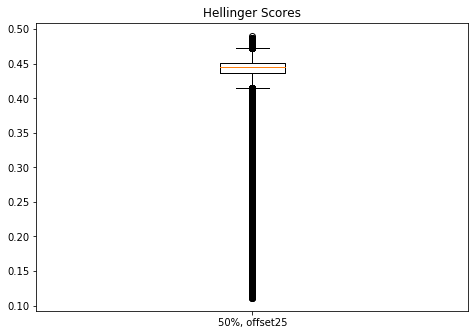

In [41]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
#ax.set_xticks([1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels(['50%, offset25'])
ax.boxplot(flat_H_off25_thin0p1, showfliers=True)
plt.title("Hellinger Scores")

plt.show()



In [ ]:
#PRETTY SURE I CAN STOP HERE
#Transpose the matrices so they are people # rows and SNP # columns
maj_homo_train_T = maj_homozygous_train.transpose()
hetero_train_T = heterozygous_train.transpose()
min_homo_train_T = min_homozygous_train.transpose()

label_maj_homo = np.zeros((maj_homo_train_T.shape[0]))
label_min_homo = np.zeros((min_homo_train_T.shape[0]))
label_hetero = np.zeros((hetero_train_T.shape[0]))

for i in range(maj_homo_train_T.shape[0]):
    label_maj_homo[i] =  maj_homo_train_T[i][idx_snp]
    label_min_homo[i] = min_homo_train_T[i][idx_snp]
    label_hetero[i] = hetero_train_T[i][idx_snp]

label_maj_homo_cM = cM_map[idx_snp][1]
new_training_scaled_cM = np.zeros((people_training, 2*offset))
new_training_scaled_cM_min = np.zeros((people_training, 2*offset))
new_training_scaled_cM_hetero = np.zeros((people_training, 2*offset))

diffs = np.zeros((people_training, 2*offset))

#creates models
diff_val = 0.001
#for the 2*offset SNPs being used as data
for cMpos in range(2*offset):
    for person in range(people_training):
        #need to account for not using the actual SNP being imputed
        if cMpos < offset:
            #calculate cM pos difference between SNP being imputed + reference SNP
            diff = np.abs(label_maj_homo_cM - cM_map[idx_snp - offset+ cMpos][1])
            diffs[person][cMpos] = diff
            #if difference is zero, they have same cM pos position and should stick together
            #this only happens at the very first few SNPs (probably)
            if diff == 0:  
                diff = diff_val #can change this value
            
            unscaled_data = maj_homo_train_T[person][idx_snp - offset + cMpos]
            unscaled_data_min = min_homo_train_T[person][idx_snp - offset + cMpos]
            unscaled_data_hetero = hetero_train_T[person][idx_snp - offset + cMpos]

            #set 0 vals to -1 (so we don't just set ~1/2+ of our data to 0)
            if unscaled_data == 0:
                unscaled_data = -1
            #new training data is scaled by reciprocal of difference
            #so close SNPs have higher impact on imputed val
            new_training_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
            new_training_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
            new_training_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )

        else:
            #print("cMpos", cMpos, "cMpos Dist", cM_map[idx_snp - offset+ cMpos +1][1])
            diff = np.abs(label_maj_homo_cM - cM_map[idx_snp - offset+ cMpos +1][1])
            diffs[person][cMpos] = diff

            if diff == 0:  
                diff = diff_val 
            unscaled_data = maj_homo_train_T[person][idx_snp - offset+ cMpos + 1]
            unscaled_data_min = min_homo_train_T[person][idx_snp - offset + cMpos + 1]
            unscaled_data_hetero = hetero_train_T[person][idx_snp - offset + cMpos + 1]

            #set 0 vals to -1 (so we don't just set ~1/2+ of our data to 0)
            if unscaled_data == 0:
                unscaled_data = -1
            #new training data is scaled by reciprocal of difference
            #so close SNPs have higher impact on imputed val
            new_training_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
            new_training_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
            new_training_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )


snpX_maj = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")
snpX_min = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")
snpX_hetero = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")

snpX_maj.fit(new_training_scaled_cM, label_maj_homo)
snpX_min.fit(new_training_scaled_cM_min, label_min_homo)
snpX_hetero.fit(new_training_scaled_cM_hetero, label_hetero)


In [ ]:
#function to run through many times (as we do our model)
import math

def train_and_test(offset, idx_snp):
    #training
    label_maj_homo = np.zeros((maj_homo_train_T.shape[0]))
    label_min_homo = np.zeros((min_homo_train_T.shape[0]))
    label_hetero = np.zeros((hetero_train_T.shape[0]))

    for i in range(maj_homo_train_T.shape[0]):
        label_maj_homo[i] =  maj_homo_train_T[i][idx_snp]
        label_min_homo[i] = min_homo_train_T[i][idx_snp]
        label_hetero[i] = hetero_train_T[i][idx_snp]

    label_maj_homo_cM = cM_map[idx_snp][1]
    new_training_scaled_cM = np.zeros((people_training, 2*offset))
    new_training_scaled_cM_min = np.zeros((people_training, 2*offset))
    new_training_scaled_cM_hetero = np.zeros((people_training, 2*offset))

    diffs = np.zeros((people_training, 2*offset))

    #creates models
    diff_val = 0.001
    #for the 2*offset SNPs being used as data
    for cMpos in range(2*offset):
        for person in range(people_training):
            #need to account for not using the actual SNP being imputed
            if cMpos < offset:
                #calculate cM pos difference between SNP being imputed + reference SNP
                diff = np.abs(label_maj_homo_cM - cM_map[idx_snp - offset+ cMpos][1])
                diffs[person][cMpos] = diff
                #if difference is zero, they have same cM pos position and should stick together
                #this only happens at the very first few SNPs (probably)
                if diff == 0:  
                    diff = diff_val #can change this value

                unscaled_data = maj_homo_train_T[person][idx_snp - offset + cMpos]
                unscaled_data_min = min_homo_train_T[person][idx_snp - offset + cMpos]
                unscaled_data_hetero = hetero_train_T[person][idx_snp - offset + cMpos]

                #set 0 vals to -1 (so we don't just set ~1/2+ of our data to 0)
                if unscaled_data == 0:
                    unscaled_data = -1
                #new training data is scaled by reciprocal of difference
                #so close SNPs have higher impact on imputed val
                new_training_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
                new_training_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
                new_training_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )

            else:
                #print("cMpos", cMpos, "cMpos Dist", cM_map[idx_snp - offset+ cMpos +1][1])
                diff = np.abs(label_maj_homo_cM - cM_map[idx_snp - offset+ cMpos +1][1])
                diffs[person][cMpos] = diff

                if diff == 0:  
                    diff = diff_val 
                unscaled_data = maj_homo_train_T[person][idx_snp - offset+ cMpos + 1]
                unscaled_data_min = min_homo_train_T[person][idx_snp - offset + cMpos + 1]
                unscaled_data_hetero = hetero_train_T[person][idx_snp - offset + cMpos + 1]

                #set 0 vals to -1 (so we don't just set ~1/2+ of our data to 0)
                if unscaled_data == 0:
                    unscaled_data = -1
                #new training data is scaled by reciprocal of difference
                #so close SNPs have higher impact on imputed val
                new_training_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
                new_training_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
                new_training_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )


    snpX_maj = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")
    snpX_min = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")
    snpX_hetero = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")

    snpX_maj.fit(new_training_scaled_cM, label_maj_homo)
    snpX_min.fit(new_training_scaled_cM_min, label_min_homo)
    snpX_hetero.fit(new_training_scaled_cM_hetero, label_hetero)
    
    #testing
    label_maj_homo_test = np.zeros((maj_homo_test_T.shape[0]))
    label_min_homo_test = np.zeros((min_homo_test_T.shape[0]))
    label_hetero_test = np.zeros((hetero_test_T.shape[0]))

    for i in range(maj_homo_test_T.shape[0]):
        label_maj_homo_test[i] =  maj_homo_test_T[i][idx_snp]
        label_min_homo_test[i] =  min_homo_test_T[i][idx_snp]
        label_hetero_test[i] =  hetero_test_T[i][idx_snp]

    new_testing_scaled_cM = np.zeros((people, 2*offset))
    new_testing_scaled_cM_min = np.zeros((people, 2*offset))
    new_testing_scaled_cM_hetero = np.zeros((people, 2*offset))

    label_maj_homo_cM = cM_map[idx_snp][1]

    for cMpos in range(2*offset):
        for person in range(people):
            if cMpos < offset:
                current_idx = idx_snp - cMpos - 1
                if current_idx in missing_indices:
                    current_idx -= 1
                #calculate cM pos difference between SNP being imputed + reference SNP
                diff = np.abs(label_maj_homo_cM - cM_map[current_idx][1])

                if diff == 0:  
                    diff = diff_val #can change this value

                unscaled_data = maj_homo_test_T[person][current_idx]
                unscaled_data_min = min_homo_test_T[person][current_idx]
                unscaled_data_hetero = hetero_test_T[person][current_idx]

                if unscaled_data == 0:
                    unscaled_data = -1
                new_testing_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
                new_testing_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
                new_testing_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )

            else:
                current_idx = idx_snp - offset+ cMpos +1
                if current_idx in missing_indices:
                    current_idx += 1
                diff = np.abs(label_maj_homo_cM - cM_map[current_idx][1])
                if diff == 0:  
                    diff = diff_val 
                unscaled_data = maj_homo_test_T[person][current_idx]
                unscaled_data_min = min_homo_test_T[person][current_idx]
                unscaled_data_hetero = hetero_test_T[person][current_idx]

                if unscaled_data == 0:
                    unscaled_data = -1
                new_testing_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
                new_testing_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
                new_testing_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )

    predict_label_maj_100 = snpX_maj.predict(new_testing_scaled_cM)
    predict_label_min_100 = snpX_min.predict(new_testing_scaled_cM_min)
    predict_label_hetero_100 = snpX_hetero.predict(new_testing_scaled_cM_hetero)
    
    
    #Accuracy for Hellinger score
    probs_maj_homo = snpX_maj.predict_proba(new_testing_scaled_cM)
    probs_min_homo = snpX_min.predict_proba(new_testing_scaled_cM_min)
    probs_hetero = snpX_hetero.predict_proba(new_testing_scaled_cM_hetero)

    #Normalize for Hellinger score
    #if any are all one dimension rather than two, means it is never that. Add a second col anyway
    probs_het = np.zeros((probs_hetero.shape[0], 2))
    if probs_hetero.shape[1] == 1:
        for i in range((probs_hetero.shape[0])):
            probs_het[i][0] = probs_hetero[i]
    else:
        probs_het = probs_hetero

    probs_maj = np.zeros((probs_maj_homo.shape[0], 2))
    if probs_maj_homo.shape[1] == 1:
        for i in range((probs_maj_homo.shape[0])):
            probs_maj[i][0] = probs_maj_homo[i]
    else:
        probs_maj = probs_maj_homo


    probs_min = np.zeros((probs_min_homo.shape[0], 2))
    if probs_min_homo.shape[1] == 1:
        for i in range((probs_min_homo.shape[0])):
            probs_min[i][0] = probs_min_homo[i]
    else:
        probs_min = probs_min_homo

        
    #HERE --> create "normalized" distributions for the three
    prob_dist_predict = np.zeros(( probs_min.shape[0], 3))
    for person in range(probs_min.shape[0]):
        total = probs_min[person][1] + probs_maj[person][1] + probs_het[person][1]
        prob_dist_predict[person][0] = probs_maj[person][1] / total
        prob_dist_predict[person][1] = probs_het[person][1] / total
        prob_dist_predict[person][2] = probs_min[person][1] / total

    #calculate actual prob_dist_actual
    prob_dist_actual = np.zeros((probs_min.shape[0], 3))
    H_score = []

    for person in range((probs_min.shape[0])):
        sum_total = label_hetero_test[person] + label_maj_homo_test[person] +\
        label_min_homo_test[person]
        prob_dist_actual[person][0] = label_maj_homo_test[person] / sum_total
        prob_dist_actual[person][1] = label_hetero_test[person] / sum_total
        prob_dist_actual[person][2] = label_min_homo_test[person] / sum_total
    
        sqrt_sum = math.sqrt(prob_dist_actual[person][0] * prob_dist_predict[person][0]) + \
            math.sqrt(prob_dist_actual[person][1] * prob_dist_predict[person][1]) + \
            math.sqrt(prob_dist_actual[person][2] * prob_dist_predict[person][2])
        if sqrt_sum > 1.0:
            sqrt_sum = 1.0
        H_score.append(1 - math.sqrt(1-sqrt_sum))
    return H_score


In [ ]:
#RUN THIS

def training(offset):
    #for a given offset, train this model on all data
    
    #we are only going to train when we're offset or more away from the ends
    imputable_maj_train = maj_homo_train_T[:, offset:maj_homo_train_T.shape[1]-offset]
    imputable_min_train = min_homo_train_T[:, offset:maj_homo_train_T.shape[1]-offset]
    imputable_het_train = hetero_train_T[:, offset:maj_homo_train_T.shape[1]-offset]

    imputable_snps = imputable_maj_train[1]
    mega_training_data_maj = np.zeros((people_training * len(imputable_snps), 2*offset))
    mega_training_data_min = np.zeros((people_training * len(imputable_snps), 2*offset))
    mega_training_data_het = np.zeros((people_training * len(imputable_snps), 2*offset))
    mega_labels_maj = np.zeros((len(imputable_snps) * people_training))
    mega_labels_min = np.zeros((len(imputable_snps) * people_training))
    mega_labels_het = np.zeros((len(imputable_snps) * people_training))

                
    #from imputable_*_train remove all of the indices that have been thinned out
    #call it thinned_*_train
    
    #then iterate on every snp and multiply by centi-morgans
    
    for SNP in range(len(imputable_snps)):
        print(SNP)
        
        
        #labels vectors are 250 people long
        label_maj_homo = np.zeros((imputable_maj_train.shape[0]))
        label_min_homo = np.zeros((imputable_min_train.shape[0]))
        label_hetero = np.zeros((imputable_het_train.shape[0]))

        #generate a label for each person
        for person in range(maj_homo_train_T.shape[0]):
            label_maj_homo[person] =  imputable_maj_train[person, int(SNP)]
            label_min_homo[person] = imputable_min_train[person, int(SNP)]
            label_hetero[person] = imputable_het_train[person, int(SNP)]

        #add labels to label vector
        mega_labels_maj[int(SNP * people_training) : int((SNP + 1) * people_training)] = label_maj_homo
        mega_labels_min[int(SNP * people_training) : int((SNP + 1) * people_training)] = label_min_homo
        mega_labels_het[int(SNP * people_training) : int((SNP + 1) * people_training)] = label_hetero
        

            
        #find cM value for label
        label_maj_homo_cM = cM_map[SNP][1]
        new_training_scaled_cM = np.zeros((people_training, 2*offset))
        new_training_scaled_cM_min = np.zeros((people_training, 2*offset))
        new_training_scaled_cM_hetero = np.zeros((people_training, 2*offset))

        diffs = np.zeros((people_training, 2*offset))

        #creates models
        diff_val = 0.001
        #for the 2*offset SNPs being used as data
        for cMpos in range(2*offset):
            for person in range(people_training):
                #need to account for not using the actual SNP being imputed
                if cMpos < offset:
                    current_idx = idx_snp - offset+ cMpos
                    
                    if current_idx in missing_indices:
                        current_idx -= 1

                    #calculate cM pos difference between SNP being imputed + reference SNP
                    diff = np.abs(label_maj_homo_cM - cM_map[current_idx][1])
                    diffs[person][cMpos] = diff

                    if diff == 0:  
                        diff = diff_val 

                    unscaled_data = maj_homo_train_T[person][current_idx]
                    unscaled_data_min = min_homo_train_T[person][current_idx]
                    unscaled_data_hetero = hetero_train_T[person][current_idx]

                    if unscaled_data == 0:
                        unscaled_data = -1

                    new_training_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
                    new_training_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
                    new_training_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )

                else:
                    current_idx = idx_snp - offset+ cMpos +1
                    if current_idx in missing_indices:
                        current_idx += 1

                    diff = np.abs(label_maj_homo_cM - cM_map[current_idx][1])
                    diffs[person][cMpos] = diff

                    if diff == 0:  
                        diff = diff_val 
                    unscaled_data = maj_homo_train_T[person][current_idx]
                    unscaled_data_min = min_homo_train_T[person][current_idx]
                    unscaled_data_hetero = hetero_train_T[person][current_idx]

                    #set 0 vals to -1 (so we don't just set ~1/2+ of our data to 0)
                    if unscaled_data == 0:
                        unscaled_data = -1
                    #new training data is scaled by reciprocal of difference
                    #so close SNPs have higher impact on imputed val
                    new_training_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
                    new_training_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
                    new_training_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )

        #add to the mega data
        mega_training_data_maj[SNP * people_training : (SNP + 1) * people_training, :] = new_training_scaled_cM
        mega_training_data_min[SNP * people_training : (SNP + 1) * people_training, :] = new_training_scaled_cM_min
        mega_training_data_het[SNP * people_training : (SNP + 1) * people_training, :] = new_training_scaled_cM_hetero
        
        
        
    snpX_maj = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")
    snpX_min = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")
    snpX_het = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")

    snpX_maj.fit(mega_training_data_maj, mega_labels_maj)
    snpX_min.fit(mega_training_data_min, mega_labels_min)
    snpX_het.fit(mega_training_data_het, mega_labels_het)

In [ ]:
#REWRITE THIS
def testing(missing_indices):
    H_scores_final = []
    for idx_snp in missing_indices:
        label_maj_homo_test = np.zeros((maj_homo_test_T.shape[0]))
        label_min_homo_test = np.zeros((min_homo_test_T.shape[0]))
        label_hetero_test = np.zeros((hetero_test_T.shape[0]))

        for i in range(maj_homo_test_T.shape[0]):
            label_maj_homo_test[i] =  maj_homo_test_T[i][idx_snp]
            label_min_homo_test[i] =  min_homo_test_T[i][idx_snp]
            label_hetero_test[i] =  hetero_test_T[i][idx_snp]

        new_testing_scaled_cM = np.zeros((people, 2*offset))
        new_testing_scaled_cM_min = np.zeros((people, 2*offset))
        new_testing_scaled_cM_hetero = np.zeros((people, 2*offset))

        label_maj_homo_cM = cM_map[idx_snp][1]

        for cMpos in range(2*offset):
            for person in range(people):
                if cMpos < offset:
                    current_idx = idx_snp - cMpos - 1
                    if current_idx in missing_indices:
                        current_idx -= 1
                    #calculate cM pos difference between SNP being imputed + reference SNP
                    diff = np.abs(label_maj_homo_cM - cM_map[current_idx][1])

                    if diff == 0:  
                        diff = diff_val #can change this value

                    unscaled_data = maj_homo_test_T[person][current_idx]
                    unscaled_data_min = min_homo_test_T[person][current_idx]
                    unscaled_data_hetero = hetero_test_T[person][current_idx]

                    if unscaled_data == 0:
                        unscaled_data = -1
                    new_testing_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
                    new_testing_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
                    new_testing_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )

                else:
                    current_idx = idx_snp - offset+ cMpos +1
                    if current_idx in missing_indices:
                        current_idx += 1
                    diff = np.abs(label_maj_homo_cM - cM_map[current_idx][1])
                    if diff == 0:  
                        diff = diff_val 
                    unscaled_data = maj_homo_test_T[person][current_idx]
                    unscaled_data_min = min_homo_test_T[person][current_idx]
                    unscaled_data_hetero = hetero_test_T[person][current_idx]

                    if unscaled_data == 0:
                        unscaled_data = -1
                    new_testing_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
                    new_testing_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
                    new_testing_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )

        predict_label_maj_100 = snpX_maj.predict(new_testing_scaled_cM)
        predict_label_min_100 = snpX_min.predict(new_testing_scaled_cM_min)
        predict_label_hetero_100 = snpX_hetero.predict(new_testing_scaled_cM_hetero)


        #Accuracy for Hellinger score
        probs_maj_homo = snpX_maj.predict_proba(new_testing_scaled_cM)
        probs_min_homo = snpX_min.predict_proba(new_testing_scaled_cM_min)
        probs_hetero = snpX_hetero.predict_proba(new_testing_scaled_cM_hetero)

        #Normalize for Hellinger score
        #if any are all one dimension rather than two, means it is never that. Add a second col anyway
        probs_het = np.zeros((probs_hetero.shape[0], 2))
        if probs_hetero.shape[1] == 1:
            for i in range((probs_hetero.shape[0])):
                probs_het[i][0] = probs_hetero[i]
        else:
            probs_het = probs_hetero

        probs_maj = np.zeros((probs_maj_homo.shape[0], 2))
        if probs_maj_homo.shape[1] == 1:
            for i in range((probs_maj_homo.shape[0])):
                probs_maj[i][0] = probs_maj_homo[i]
        else:
            probs_maj = probs_maj_homo


        probs_min = np.zeros((probs_min_homo.shape[0], 2))
        if probs_min_homo.shape[1] == 1:
            for i in range((probs_min_homo.shape[0])):
                probs_min[i][0] = probs_min_homo[i]
        else:
            probs_min = probs_min_homo


        #HERE --> create "normalized" distributions for the three
        prob_dist_predict = np.zeros(( probs_min.shape[0], 3))
        for person in range(probs_min.shape[0]):
            total = probs_min[person][1] + probs_maj[person][1] + probs_het[person][1]
            prob_dist_predict[person][0] = probs_maj[person][1] / total
            prob_dist_predict[person][1] = probs_het[person][1] / total
            prob_dist_predict[person][2] = probs_min[person][1] / total

        #calculate actual prob_dist_actual
        prob_dist_actual = np.zeros((probs_min.shape[0], 3))
        H_score = []

        for person in range((probs_min.shape[0])):
            sum_total = label_hetero_test[person] + label_maj_homo_test[person] +\
            label_min_homo_test[person]
            prob_dist_actual[person][0] = label_maj_homo_test[person] / sum_total
            prob_dist_actual[person][1] = label_hetero_test[person] / sum_total
            prob_dist_actual[person][2] = label_min_homo_test[person] / sum_total

            sqrt_sum = math.sqrt(prob_dist_actual[person][0] * prob_dist_predict[person][0]) + \
                math.sqrt(prob_dist_actual[person][1] * prob_dist_predict[person][1]) + \
                math.sqrt(prob_dist_actual[person][2] * prob_dist_predict[person][2])
            if sqrt_sum > 1.0:
                sqrt_sum = 1.0
            H_score.append(1 - math.sqrt(1-sqrt_sum))
        H_scores_final.append(H_score)
    return H_scores_final


In [ ]:
#RUN THIS SECOND
training(offset = 25)

In [ ]:
#RUN FIFTH, CHANGE VALUES
flat_H_offset25_mask = [item for sublist in H_scores_offset24 for item in sublist]
np.savetxt("H_data_50%mask_25offset_RF", flat_H_offset25_mask, delimiter = ' ')


In [ ]:
maj_homo_test_T = maj_homozygous_test.transpose()
hetero_test_T = heterozygous_test.transpose()
min_homo_test_T = min_homozygous_test.transpose()

label_maj_homo_test = np.zeros((maj_homo_test_T.shape[0]))
label_min_homo_test = np.zeros((min_homo_test_T.shape[0]))
label_hetero_test = np.zeros((hetero_test_T.shape[0]))

for i in range(maj_homo_test_T.shape[0]):
    label_maj_homo_test[i] =  maj_homo_test_T[i][idx_snp]
    label_min_homo_test[i] =  min_homo_test_T[i][idx_snp]
    label_hetero_test[i] =  hetero_test_T[i][idx_snp]

new_testing_scaled_cM = np.zeros((people, 2*offset))
new_testing_scaled_cM_min = np.zeros((people, 2*offset))
new_testing_scaled_cM_hetero = np.zeros((people, 2*offset))

label_maj_homo_cM = cM_map[idx_snp][1]

for cMpos in range(2*offset):
    for person in range(people):
        if cMpos < offset:
            current_idx = idx_snp - cMpos - 1
            if current_idx in missing_idx:
                current_idx -= 1
            #calculate cM pos difference between SNP being imputed + reference SNP
            diff = np.abs(label_maj_homo_cM - cM_map[current_idx][1])

            if diff == 0:  
                diff = diff_val #can change this value
            
            unscaled_data = maj_homo_test_T[person][current_idx]
            unscaled_data_min = min_homo_test_T[person][current_idx]
            unscaled_data_hetero = hetero_test_T[person][current_idx]
            
            if unscaled_data == 0:
                unscaled_data = -1
            new_testing_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
            new_testing_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
            new_testing_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )

        else:
            current_idx = idx_snp - offset+ cMpos +1
            if current_idx in missing_idx:
                current_idx += 1
            diff = np.abs(label_maj_homo_cM - cM_map[current_idx][1])
            if diff == 0:  
                diff = diff_val 
            unscaled_data = maj_homo_test_T[person][current_idx]
            unscaled_data_min = min_homo_test_T[person][current_idx]
            unscaled_data_hetero = hetero_test_T[person][current_idx]

            if unscaled_data == 0:
                unscaled_data = -1
            new_testing_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
            new_testing_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
            new_testing_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )

predict_label_maj_100 = snpX_maj.predict(new_testing_scaled_cM)
predict_label_min_100 = snpX_min.predict(new_testing_scaled_cM_min)
predict_label_hetero_100 = snpX_hetero.predict(new_testing_scaled_cM_hetero)



#calculate accuracy
accuracy = 0
for i in range(len(predict_label_maj_100)):
    if predict_label_maj_100[i] == label_maj_homo_test[i]:
        accuracy += 1
acc_score = accuracy / len(predict_label_maj_100)

min_accuracy = 0
for i in range(len(predict_label_min_100)):
    if predict_label_min_100[i] == label_min_homo_test[i]:
        min_accuracy += 1
acc_score = min_accuracy / len(predict_label_min_100)

hetero_accuracy = 0
for i in range(len(predict_label_hetero_100)):
    if predict_label_hetero_100[i] == label_hetero_test[i]:
        hetero_accuracy += 1
acc_score = hetero_accuracy / len(predict_label_hetero_100)



In [ ]:
#calculate probability of labels
#gives first probability of 0, then of 1
#will want one of these (the 1th column) for use in Hellinger score
probs_maj_homo = snpX_maj.predict_proba(new_testing_scaled_cM)
probs_min_homo = snpX_min.predict_proba(new_testing_scaled_cM_min)
probs_hetero = snpX_hetero.predict_proba(new_testing_scaled_cM_hetero)

#Normalize for Hellinger score
#if any are all one dimension rather than two, means it is never that. Add a second col anyway
probs_het = np.zeros((probs_hetero.shape[0], 2))
if probs_hetero.shape[1] == 1:
    for i in range((probs_hetero.shape[0])):
        probs_het[i][0] = probs_hetero[i]
else:
    probs_het = probs_hetero
    
probs_maj = np.zeros((probs_maj_homo.shape[0], 2))
if probs_maj_homo.shape[1] == 1:
    for i in range((probs_maj_homo.shape[0])):
        probs_maj[i][0] = probs_maj_homo[i]
else:
    probs_maj = probs_maj_homo

    
probs_min = np.zeros((probs_min_homo.shape[0], 2))
if probs_min_homo.shape[1] == 1:
    for i in range((probs_min_homo.shape[0])):
        probs_min[i][0] = probs_min_homo[i]
else:
    probs_min = probs_min_homo

prob_dist_predict = np.zeros(( probs_min.shape[0], 3))
for person in range(probs_min.shape[0]):
    total = probs_min[person][1] + probs_maj[person][1] + probs_het[person][1]
    prob_dist_predict[person][0] = probs_maj[person][1] / total
    prob_dist_predict[person][1] = probs_het[person][1] / total
    prob_dist_predict[person][2] = probs_min[person][1] / total

#print(prob_dist_predict)

In [ ]:
#create "labels" vector for training
#starting with major homozygous